In [126]:
from leicaexperiment import Experiment
e = Experiment('data/experiment--2015_03_21_17_09_56 kopi')

In [127]:
rows = e.rows(0,0)
cols = e.columns(0,0)
rows, cols

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [128]:
import imreg_dft as imreg
from skimage import io

In [129]:
translations = []
#for row in rows:
row = 0
prev_p = None
for col in cols:
    p = e.image(0, 0, col, row)
    if prev_p:
        img1 = io.imread(prev_p)
        img2 = io.imread(p)
        translations.append(imreg.translation(img1, img2) + (row, col))
    prev_p = p

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt

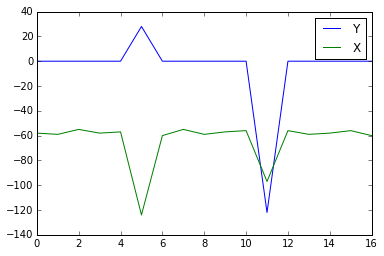

In [131]:
plt.plot([t[0][0] for t in translations])
plt.plot([t[0][1] for t in translations])
plt.legend(('Y', 'X'));

In [132]:
xs = [t[0][1] for t in translations]

In [133]:
[print(x, end=' ') for x in xs];

-58 -59 -55 -58 -57 -124 -60 -55 -59 -57 -56 -97 -56 -59 -58 -56 -60 

In [134]:
import numpy as np

In [135]:
np.median(xs)

-58.0

In [136]:
from statsmodels.formula.api import ols

In [137]:
regression = ols('data ~ x', data=dict(data=xs, x=cols[1:])).fit()

In [138]:
outliers_test = regression.outlier_test()
outliers_test

,student_resid,unadj_p,bonf(p)
0,0.418566,0.681884,1.000000
1,0.341359,0.737903,1.000000
2,0.551229,0.590166,1.000000
3,0.365160,0.720450,1.000000
4,0.405583,0.691180,1.000000
5,-6.088405,0.000028,0.000476
6,0.219058,0.829766,1.000000
7,0.476374,0.641157,1.000000
8,0.251997,0.804705,1.000000
9,0.349492,0.731922,1.000000


In [140]:
outliers_test.icol(2) < 1

0     False
1     False
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11     True
12    False
13    False
14    False
15    False
16    False
Name: bonf(p), dtype: bool

In [142]:
outliers = np.array(regression.outlier_test().icol(2) < 1)

In [143]:
xs = np.array(xs)
xs[outliers] = np.median(xs)

In [148]:
np.std(xs), np.mean(xs), np.median(xs)

(1.5361841008471289, -57.588235294117645, -58.0)

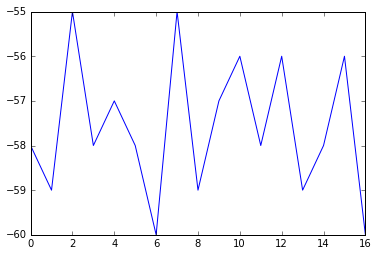

In [150]:
plt.plot(xs)

In [151]:
width = 512*len(cols) + xs.sum()
width

8237

In [152]:
merged = np.zeros((512, width), dtype=np.uint8)

In [153]:
merged[:,0:512] = io.imread(e.image(0,0,0,0))
for col in cols[1:]:
    p = e.image(0,0,col,0)
    offset = sum(xs[:col])
    start = 512*col + offset
    end = start + 512
    merged[:,start:end] = io.imread(p)

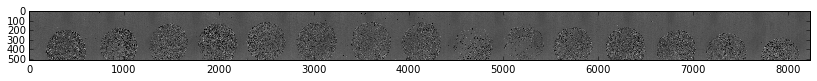

In [154]:
plt.figure(figsize=(14,3))
io.imshow(merged);

In [155]:
def cancel_outliers(data, x, model='data ~ x'):
    """Sets outliers to median(data), assuming statistical model `data ~ x`.
    
    Parameters
    ----------
    data : array like
    x : array like
    model : patsy formula (R compatible)
        See http://patsy.readthedocs.org/en/latest/overview.html
    
    Returns
    -------
    ndarray
        Data with outliers set to median(data).
    """
    equal = False
    i = 0
    while not equal:
        if i > 100:
            raise AssertionError('cancel_outliers should converge')
        before = np.copy(data)
        regression = ols(model, data=dict(data=data, x=x)).fit()
        outliers = np.array(regression.outlier_test().icol(2) < 0.9)
        data[outliers] = np.median(data)
        equal = np.all(before == data)
        i += 1

    # array modified in place, return the reference anyhow
    return data

In [156]:
translations = []
for row in rows:
    prev_p = None
    for col in cols:
        p = e.image(0, 0, col, row)
        if prev_p:
            img1 = io.imread(prev_p)
            img2 = io.imread(p)
            translations.append(imreg.translation(img1, img2) + (row, col))
        prev_p = p
# sanitize data
for i in (0,1):
    translations.sort(key=lambda t: t[0][i])
    data = np.array([t[0][i] for t in translations])
    xs = np.array([t[2+i] for t in translations])
    cancel_outliers(data, xs)
    # update translations
    for n,t in enumerate(translations):
        t[0][i] = data[n]

In [157]:
# sort by col position
translations.sort(key=lambda t: t[3])

In [158]:
x_offsets = np.array([t[0][1] for t in translations])
xs = np.array([t[3] for t in translations])

In [159]:
x_offsets.mean(), x_offsets, xs

(-58.139037433155082,
 array([-58, -58, -61, -61, -61, -58, -58, -57, -58, -58, -58, -60, -60,
        -59, -59, -59, -59, -58, -58, -58, -58, -58, -60, -57, -57, -57,
        -57, -57, -56, -56, -56, -55, -55, -60, -59, -59, -58, -58, -58,
        -58, -58, -58, -58, -58, -58, -58, -61, -59, -57, -57, -57, -57,
        -57, -58, -58, -58, -58, -58, -58, -58, -58, -58, -58, -58, -58,
        -58, -58, -58, -58, -58, -60, -60, -60, -59, -59, -58, -58, -58,
        -58, -57, -57, -57, -57, -56, -56, -55, -55, -55, -61, -61, -59,
        -59, -59, -58, -58, -58, -58, -58, -58, -60, -60, -58, -58, -58,
        -58, -57, -57, -57, -57, -57, -61, -60, -59, -58, -57, -57, -57,
        -57, -57, -56, -58, -58, -58, -58, -58, -61, -60, -60, -59, -59,
        -59, -59, -58, -58, -58, -57, -56, -56, -55, -58, -58, -58, -58,
        -58, -58, -58, -58, -60, -59, -59, -59, -58, -58, -58, -59, -59,
        -59, -59, -59, -58, -58, -58, -58, -58, -57, -61, -60, -58, -58,
        -57, -57, -57, -56, -

In [162]:
x_offset = x_offsets.mean()
height = img1.shape[0]
single_width = img1.shape[1]
width = int(len(cols)*single_width + (len(cols)-1)*x_offset+0.5)
width

8228

In [163]:
row_imgs = []
for row in rows:
    merged = np.zeros((height, width), dtype=np.uint8)
    for col in cols:
        p = e.image(0,0,col,row)
        offset = int(col*x_offset)
        start = single_width*col + offset
        end = start + single_width
        merged[:,start:end] = io.imread(p)
    row_imgs.append(merged)

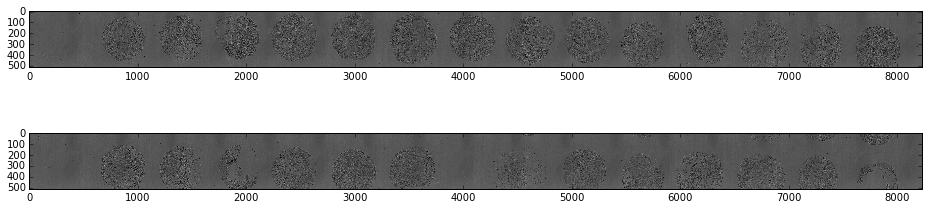

In [164]:
plt.figure(figsize=(16,4))
plt.subplot(211)
io.imshow(row_imgs[5])
plt.subplot(212)
io.imshow(row_imgs[6]);

In [165]:
imreg.translation(row_imgs[0], row_imgs[1])

(array([-59,   1]), 0.092346469689072619)

In [166]:
prev_img = None
for img in row_imgs:
    if prev_img != None:
        print(imreg.translation(prev_img, img))
    prev_img = img

(array([-59,   1]), 0.092346469689072619)
(array([-59,  -1]), 0.096479303380410372)
(array([-56,   1]), 0.087656859599399076)
(array([-60,  -1]), 0.068180134688260133)
(array([-57,   1]), 0.0094421795787797205)
(array([-57,  -1]), 0.031259448924034171)
(array([-59,   1]), 0.089459839138390007)
(array([-57,  -1]), 0.092590796095740224)
(array([-60,   1]), 0.098795208810028318)
(array([-57,  -1]), 0.099739247764711186)


/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


locking x_offset in x-stitching has major improvement in x-offset between merged rows

In [19]:
# x_offset from image to image
row_translations = [
    (np.array([-59,  -4]), 0.035486501089692105),
    (np.array([-59, -40]), 0.034187844661599319),
    (np.array([-56,  -4]), 0.023933032363228298),
    (np.array([-60,   3]), 0.028483625671276488),
    (np.array([-57,   9]), 0.0088582887109986946),
    (np.array([-57, -67]), 0.021132993011061023),
    (np.array([-59,  17]), 0.036869516028460836),
    (np.array([-57,  26]), 0.045635399401250588),
    (np.array([-60, -47]), 0.039488105063737469),
    (np.array([-57,  64]), 0.03476242897794022)]

In [82]:
# locked x_offset, not equalized
from numpy import array
row_translations = [
    (array([-59,   1]), 0.092501553962018715),
    (array([-59,  -1]), 0.096756428640844924),
    (array([-56,   1]), 0.08752472873879967),
    (array([-60,  -1]), 0.070436847914571971),
    (array([-57,   1]), 0.010626333379716245),
    (array([-57,  -1]), 0.031282231801074041),
    (array([-59,   1]), 0.090799024010073004),
    (array([-57,  -1]), 0.093382613978746226),
    (array([-60,   1]), 0.098328776970896314),
    (array([-57,  -1]), 0.099469171424364719)]

In [167]:
y_offsets = [t[0][0] for t in row_translations]
y_offset = np.mean(y_offsets)
y_offset

-58.100000000000001

In [169]:
# use calculated offsets
single_height = img1.shape[0]
height = int(len(rows)*single_height + sum(y_offsets))
height

5051

In [170]:
merged = np.zeros((height, width), dtype=np.uint8)
for row,img in enumerate(row_imgs):
    offset = int(sum(offsets[:row]))
    start = single_height*row + offset
    end = start + single_height
    merged[start:end,:] = img

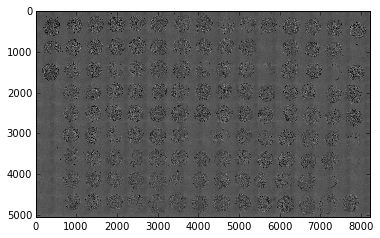

In [171]:
io.imshow(merged)

In [172]:
io.imsave(e.path + '/stitched-imreg-equalized.png', merged)

In [104]:
np.median(y_offsets)

-58.0

In [107]:
max(y_offsets)

-56

In [111]:
offsets = [t[0][1] for t in translations]

In [114]:
np.mean(offsets), np.median(offsets)

(-58.176470588235297, -58.0)

In [115]:
y_translations = []
for col in cols:
    prev_p = None
    for row in rows:
        p = e.image(0, 0, col, row)
        if prev_p:
            img1 = io.imread(prev_p)
            img2 = io.imread(p)
            y_translations.append(imreg.translation(img1, img2) + (row, col))
        prev_p = p
# sanitize data
for i in (0,1):
    y_translations.sort(key=lambda t: t[0][i])
    data = np.array([t[0][i] for t in y_translations])
    xs = np.array([t[2+i] for t in y_translations])
    cancel_outliers(data, xs)
    # update translations
    for n,t in enumerate(y_translations):
        t[0][i] = data[n]

In [124]:
y_offsets = [t[0][0] for t in y_translations]

In [125]:
np.mean(y_offsets), np.median(y_offsets)

(-58.011111111111113, -58.0)